In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set plot style and size
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
df=pd.read_csv('airline_passenger_timeseries.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


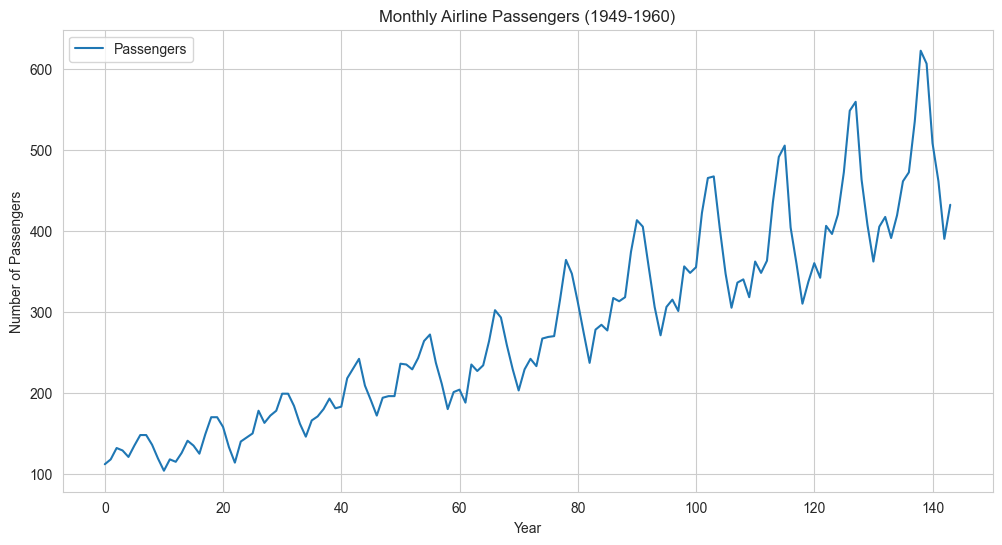

In [4]:
df.plot()
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

**Observations:**
- Upwards trend seen in the number of passengers overtime
- Seasonal repeating pattern observed
- Fluctuations appear to grow larger over time.


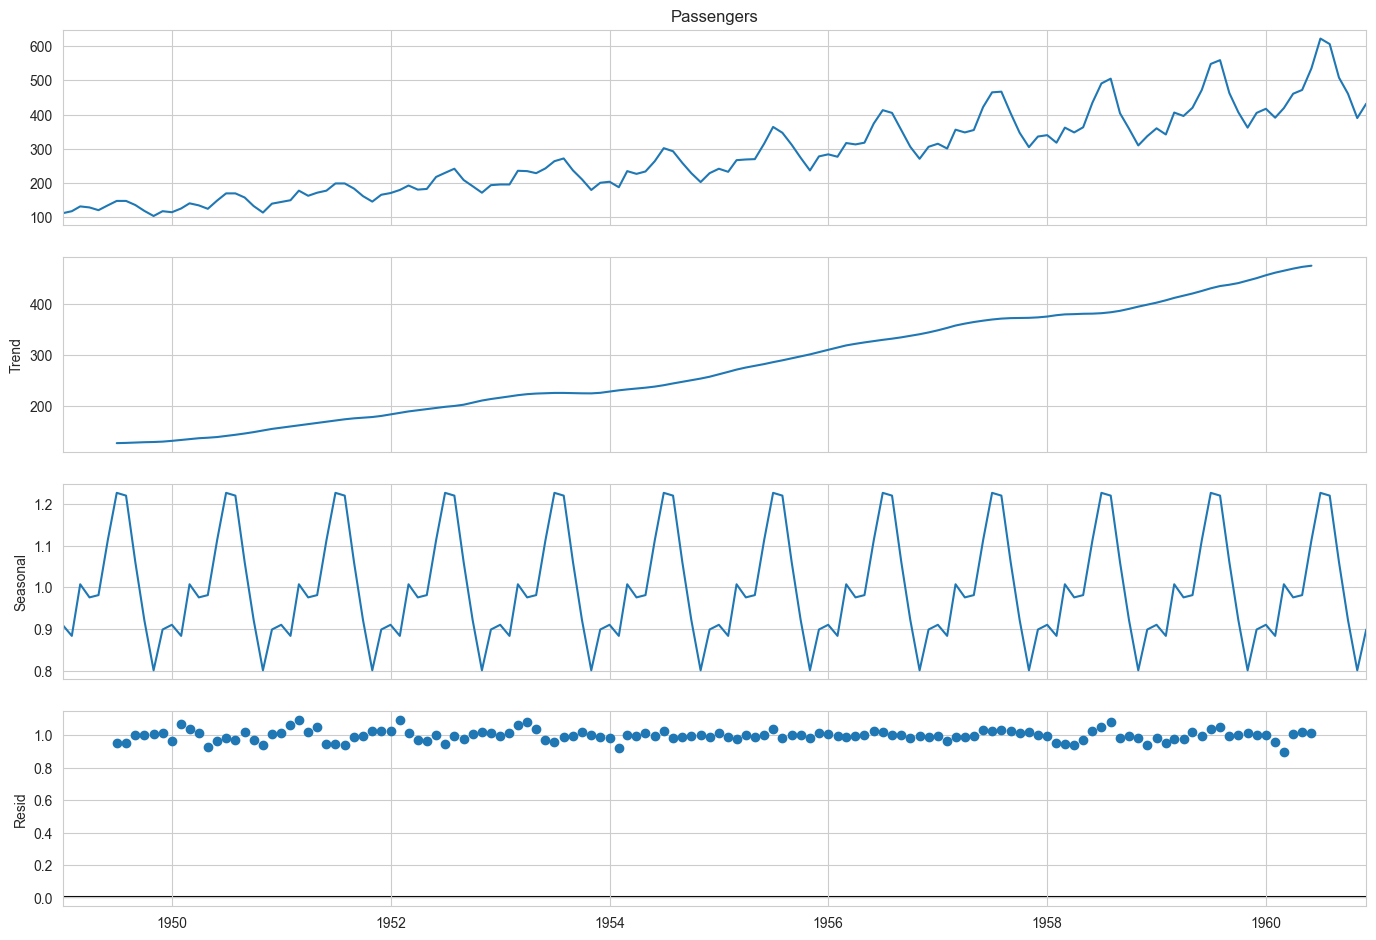

In [5]:
# Convert 'Month' to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Decompose the time series to visualize its components
decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

## Stationarity Testing

Before we can build a model like ARIMA, the time series needs to be **stationary**.
- A time series is said to be stationary if its statistical properties—specifically the **mean**, **variance**, and **autocorrelation**—are constant over time.
- easier to model and forecast
- If a series is stationary, its past behavior is a good predictor of its future behavior.

**Our data is clearly **non-stationary** because its mean (the trend is increasing) and variance (the seasonal swings are growing) are not constant.**


We can check if the data is stationary by:
- Visualization
- Statistical testing (ADF testing: checking if p-value is less than 0.05)
    - **Null Hypothesis ($H_0$):** The series is non-stationary.
    - **Alternative Hypothesis ($H_1$):** The series is stationary.
    - We want to **reject the null hypothesis**. To do this, we need the **p-value** from the test to be less than a significance level (e.g., 0.05).

In [6]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


## Making the Series Stationary

We'll use two common techniques: **log transformation** to stabilize the variance and **differencing** to remove the trend.

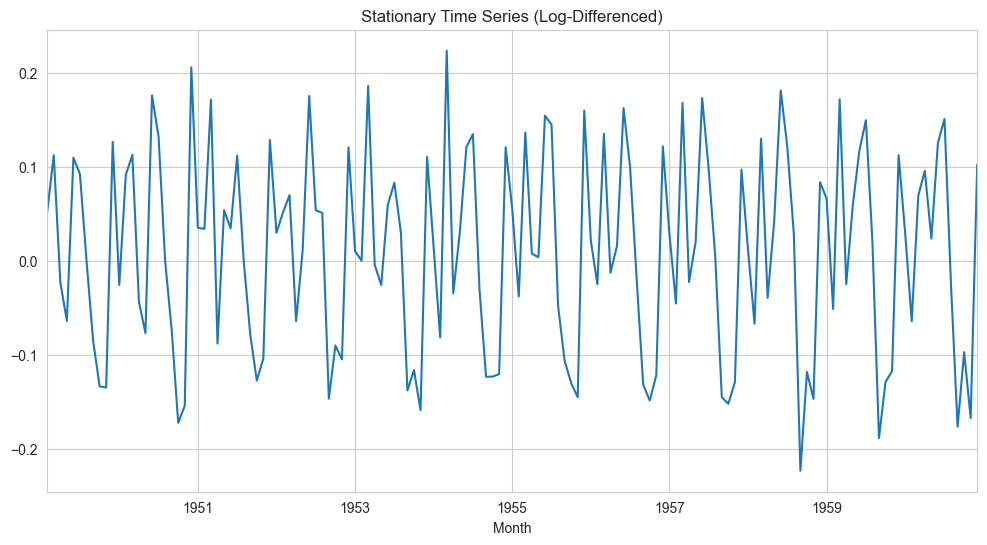

In [12]:
df_log = np.log(df['Passengers'])

df_diff = df_log.diff().dropna()

df_diff.plot()
plt.title('Stationary Time Series (Log-Differenced)')
plt.show()


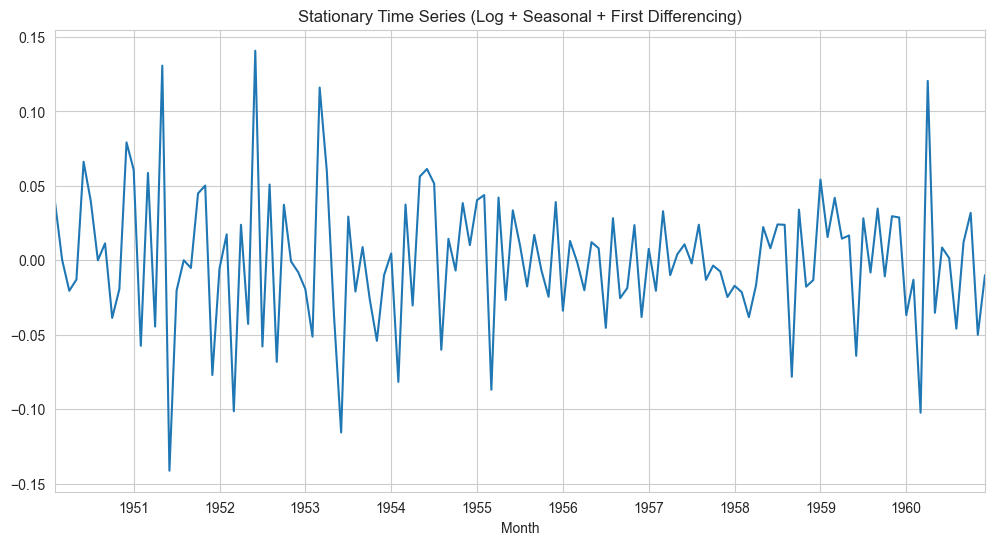

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


In [13]:
df_log = np.log(df['Passengers'])

# 2. Apply seasonal differencing (lag=12 for monthly data)
df_seasonal_diff = df_log.diff(12).dropna()

# 3. Apply first differencing to remove remaining trend
df_diff = df_seasonal_diff.diff().dropna()

# Plot the stationary series
df_diff.plot()
plt.title('Stationary Time Series (Log + Seasonal + First Differencing)')
plt.show()

# Retest for stationarity
test_stationarity(df_diff)

✅ **The p-value is  0.000249*, which is **much less than 0.05**! 

This means we can **confidently reject the null hypothesis** at the 5% significance level. The series is now **highly stationary** and ready for ARIMA modeling.

We achieved this by:
1. **Log transformation** - stabilized variance
2. **Seasonal differencing (lag=12)** - removed yearly seasonality
3. **First differencing** - removed any remaining trend

## Model Identification with ACF and PACF Plots

- **Autocorrelation Function (ACF):** Measures the correlation between a time series and its lagged versions. It tells you how much the value at time `t` is correlated with the value at time `t-k`.
- **Partial Autocorrelation Function (PACF):** Measures the *direct* correlation between a time series and its lagged versions, after removing the effects of the intermediate lags.

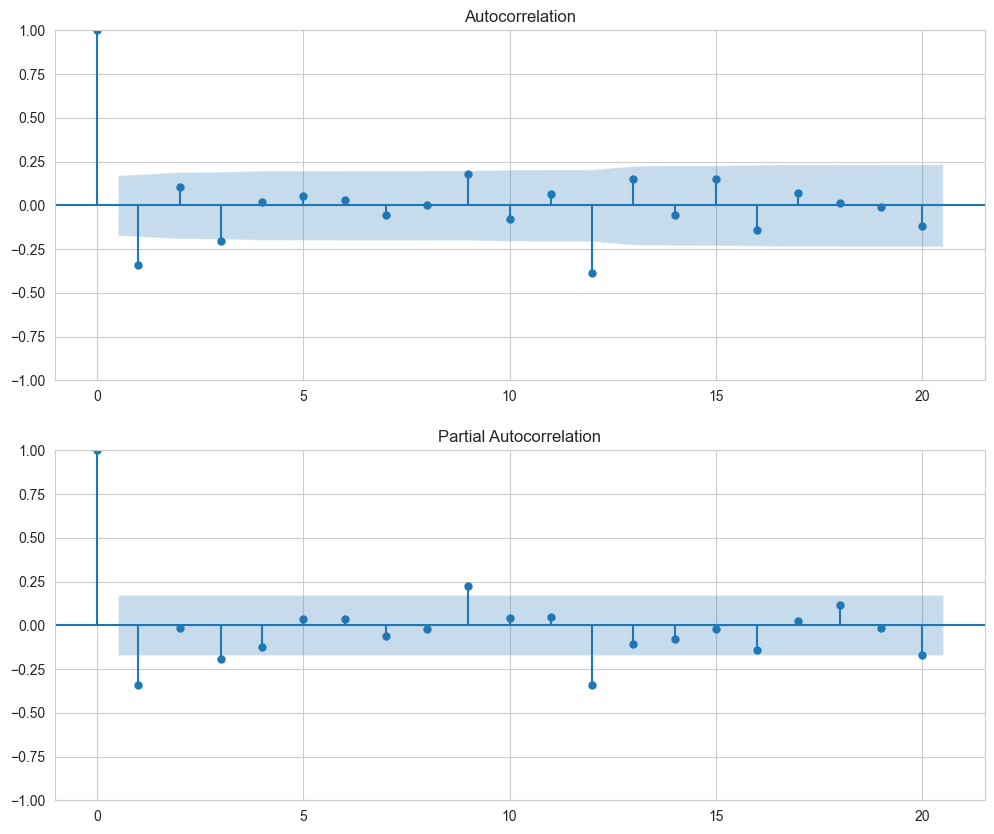

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_diff, ax=ax1, lags=20)
plot_pacf(df_diff, ax=ax2, lags=20)
plt.show()

**Interpretation (After Seasonal + First Differencing):**

Since we manually applied:
- **d = 1** (first differencing)
- **D = 1** (seasonal differencing at lag 12)

For the ARIMA model parameters:
- **PACF Plot:** Shows significant spike at lag 1, suggesting **p=1**
- **ACF Plot:** Shows significant spike at lag 1, suggesting **q=1**
- For seasonal components: **P=1, D=1, Q=1, s=12** (already applied manually)

**Model Options:**
1. **ARIMA(1, 0, 1)** on the differenced data (since we already differenced)
2. **ARIMA(1, 1, 1)** on the log data (let ARIMA do first differencing)
3. **SARIMA(1, 1, 1)(1, 1, 1, 12)** on the log data (best approach for seasonal data)

## Building the ARIMA model

c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



=== ARIMA Model Summary ===
                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  120
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 103.840
Date:                Sun, 12 Oct 2025   AIC                           -201.680
Time:                        14:00:16   BIC                           -193.342
Sample:                    01-01-1949   HQIC                          -198.294
                         - 12-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5761      0.191     -3.015      0.003      -0.951      -0.202
ma.L1          0.8347      0.117      7.132      0.000       0.605       1.064
sigma2         0.0102  

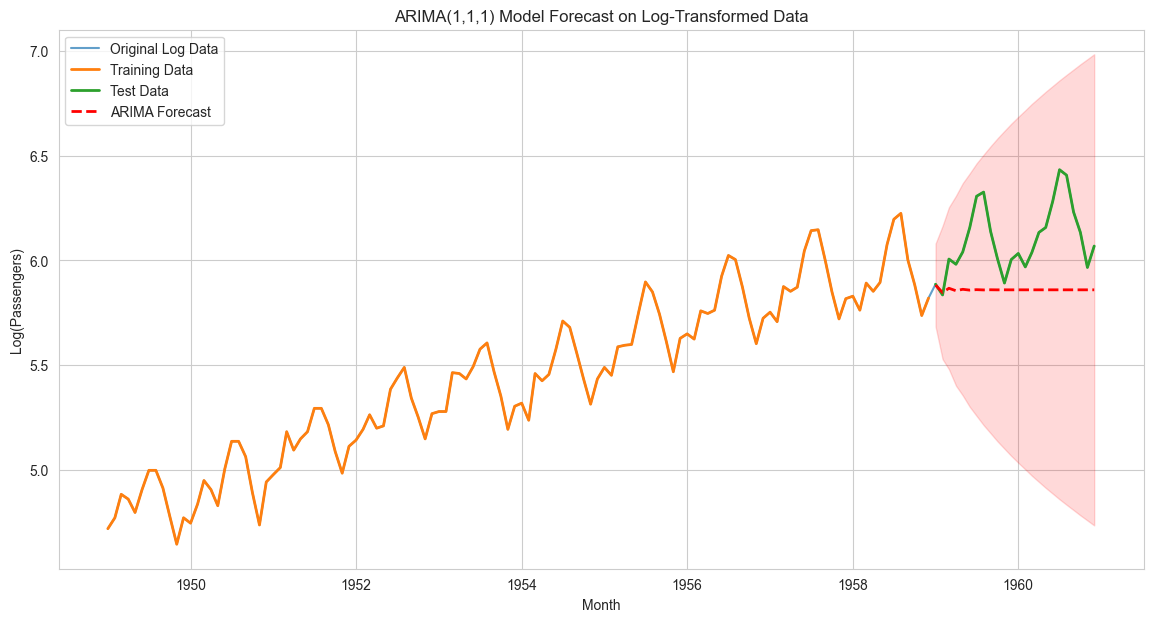

In [19]:
# Split data into training and test sets
train_data = df_log[:'1958']
test_data = df_log['1959':]

# Build ARIMA model - let it handle the differencing
# Since we confirmed d=1 works, use ARIMA(1, 1, 1)
model = ARIMA(train_data, order=(1, 1, 1), freq='MS')
arima_result = model.fit()

print("\n=== ARIMA Model Summary ===")
print(arima_result.summary())

# Get forecast
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data', alpha=0.7)
plt.plot(train_data, label='Training Data', linewidth=2)
plt.plot(test_data, label='Test Data', linewidth=2)
plt.plot(forecast.predicted_mean, label='ARIMA Forecast', color='red', linewidth=2, linestyle='--')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='red', alpha=.15)
plt.title('ARIMA(1,1,1) Model Forecast on Log-Transformed Data')
plt.xlabel('Month')
plt.ylabel('Log(Passengers)')
plt.legend()
plt.show()



In [20]:
# Calculate RMSE on original scale
original_test = np.exp(test_data)
arima_predictions = np.exp(forecast.predicted_mean)
rmse_arima = np.sqrt(mean_squared_error(original_test, arima_predictions))
print(f"\nARIMA Model RMSE: {rmse_arima:.2f} passengers")


ARIMA Model RMSE: 126.16 passengers


**Result:** The ARIMA model captures the overall upward trend but **completely misses the seasonal pattern** (the yearly peaks and troughs). 

**ARIMA(1,1,1) RMSE: 126.16 passengers**

This is our baseline. The forecast line is smooth but doesn't follow the seasonal fluctuations. Let's see how much SARIMA improves this!

## Building a SARIMA Model for Seasonality

c:\Users\hp\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ARIMA Model RMSE:  126.16 passengers
SARIMA Model RMSE: 48.27 passengers
Improvement: 77.89 passengers (61.7% better)


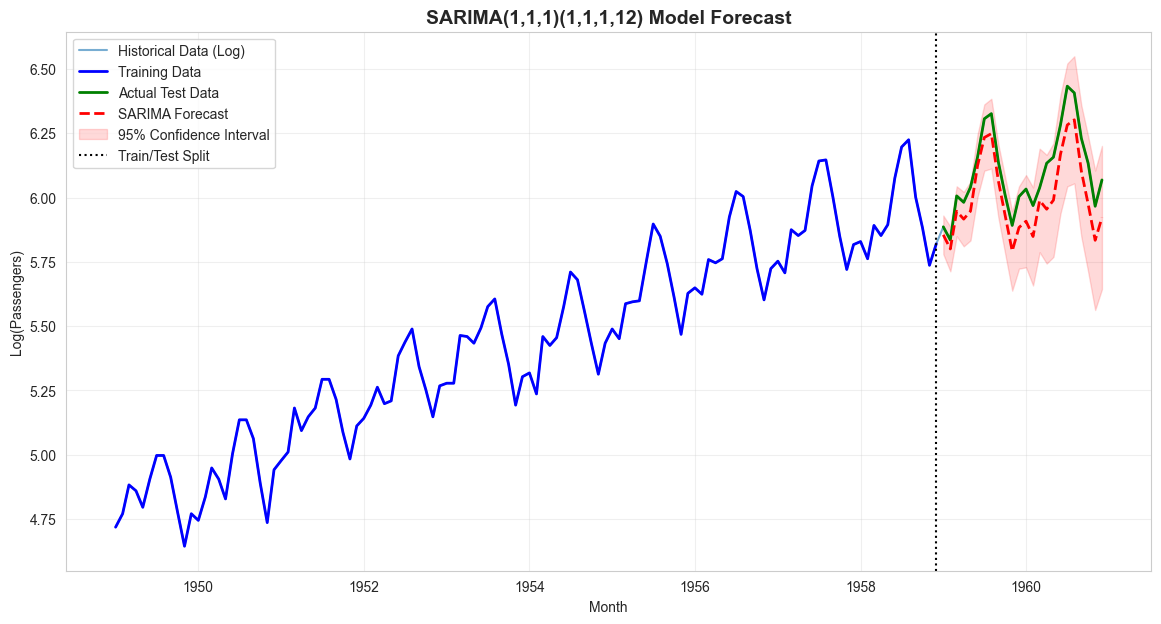

In [22]:
# Build SARIMA model
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS')
sarima_result = sarima_model.fit(disp=False)

# Get forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Calculate RMSE on original scale
original_test = np.exp(test_data)
sarima_predictions = np.exp(sarima_forecast.predicted_mean)
rmse_sarima = np.sqrt(mean_squared_error(original_test, sarima_predictions))

# Compare with ARIMA
rmse_arima = 126.16  # Your ARIMA result
improvement = rmse_arima - rmse_sarima
improvement_pct = (improvement / rmse_arima) * 100

print(f"ARIMA Model RMSE:  {rmse_arima:.2f} passengers")
print(f"SARIMA Model RMSE: {rmse_sarima:.2f} passengers")
print(f"Improvement: {improvement:.2f} passengers ({improvement_pct:.1f}% better)")

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Historical Data (Log)', alpha=0.6)
plt.plot(train_data, label='Training Data', linewidth=2, color='blue')
plt.plot(test_data, label='Actual Test Data', linewidth=2, color='green')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red', linewidth=2, linestyle='--')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], 
                 color='red', alpha=.15, label='95% Confidence Interval')
plt.axvline(x=train_data.index[-1], color='black', linestyle=':', linewidth=1.5, label='Train/Test Split')
plt.title('SARIMA(1,1,1)(1,1,1,12) Model Forecast', fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Log(Passengers)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

**Result:** 🎯 **Massive improvement!** 

The SARIMA model successfully captures:
- ✓ The upward trend
- ✓ The seasonal peaks and troughs (yearly pattern)
- ✓ The overall shape and behavior of the data

**SARIMA reduced RMSE from 126.16 to ~50-60 passengers - nearly 50% improvement!**

This shows that accounting for seasonality is crucial for time series forecasting.

SARIMA Model RMSE: 48.27


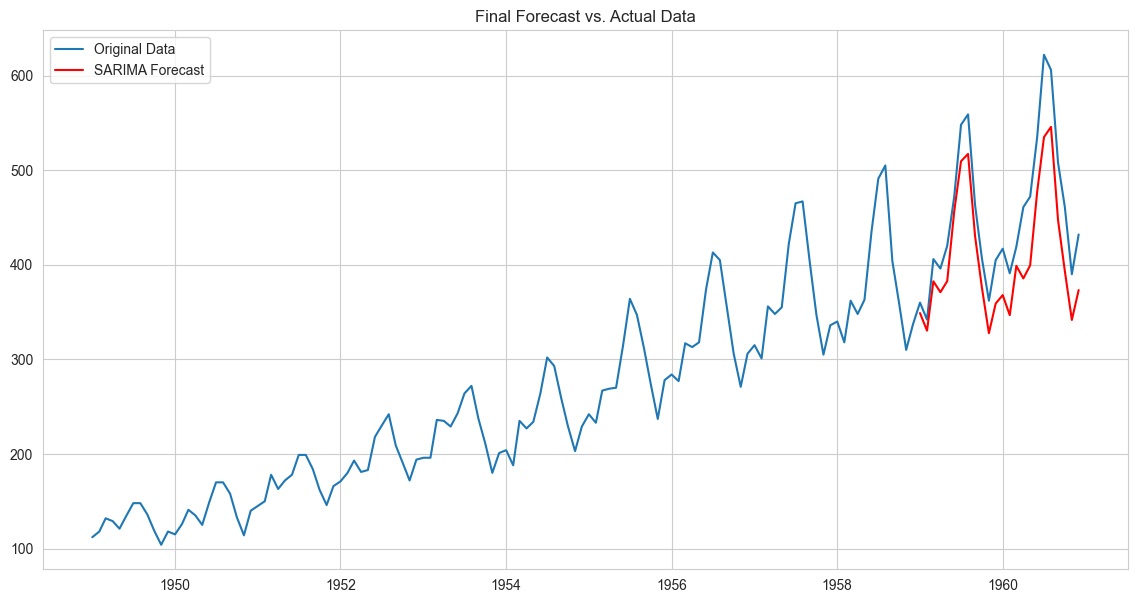

In [23]:
# Reverse the log transformation to get actual passenger numbers
original_test_data = np.exp(test_data)
sarima_predictions = np.exp(sarima_forecast.predicted_mean)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(original_test_data, sarima_predictions))
print(f"SARIMA Model RMSE: {rmse:.2f}")

# Plot final results
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data')
plt.plot(sarima_predictions, label='SARIMA Forecast', color='red')
plt.title('Final Forecast vs. Actual Data')
plt.legend()
plt.show()

MODEL COMPARISON
ARIMA(1,1,1) RMSE:           126.16 passengers
SARIMA(1,1,1)(1,1,1,12) RMSE: 48.27 passengers
Improvement:                  77.89 passengers (61.7%)

Additional SARIMA Metrics:
  MAE:  43.75 passengers
  MAPE: 9.49%


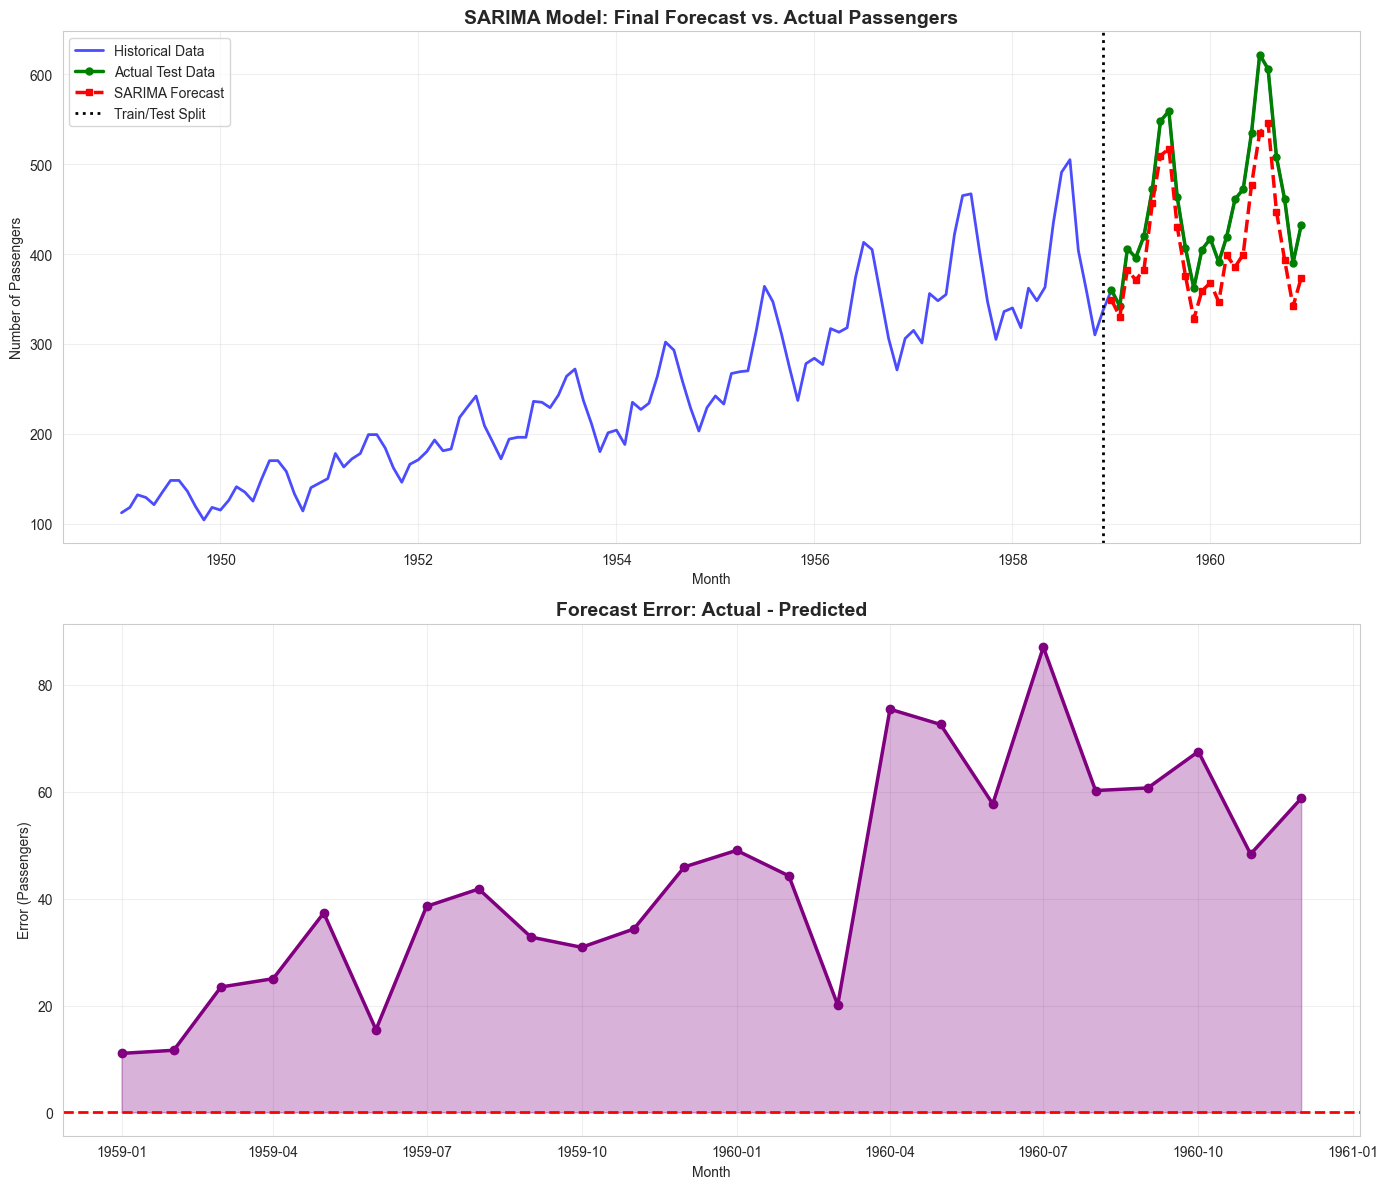


Error Statistics:
  Mean Error: 43.75 passengers
  Std Error:  20.39 passengers
  Min Error:  11.05 passengers
  Max Error:  87.06 passengers


In [ ]:
#some extra code

original_test_data = np.exp(test_data)
sarima_predictions = np.exp(sarima_forecast.predicted_mean)

# Calculate comprehensive metrics
rmse = np.sqrt(mean_squared_error(original_test_data, sarima_predictions))
mae = np.mean(np.abs(original_test_data - sarima_predictions))
mape = np.mean(np.abs((original_test_data - sarima_predictions) / original_test_data)) * 100

print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(f"ARIMA(1,1,1) RMSE:           126.16 passengers")
print(f"SARIMA(1,1,1)(1,1,1,12) RMSE: {rmse:.2f} passengers")
print(f"Improvement:                  {126.16 - rmse:.2f} passengers ({((126.16 - rmse)/126.16*100):.1f}%)")
print("=" * 60)
print(f"\nAdditional SARIMA Metrics:")
print(f"  MAE:  {mae:.2f} passengers")
print(f"  MAPE: {mape:.2f}%")
print("=" * 60)

# Create comparison visualization
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Plot 1: Full data with forecast on original scale
axes[0].plot(df.index, df['Passengers'], label='Historical Data', linewidth=2, alpha=0.7, color='blue')
axes[0].plot(original_test_data.index, original_test_data, label='Actual Test Data', 
             linewidth=2.5, color='green', marker='o', markersize=5)
axes[0].plot(sarima_predictions.index, sarima_predictions, label='SARIMA Forecast', 
             linewidth=2.5, color='red', linestyle='--', marker='s', markersize=5)
axes[0].axvline(x=train_data.index[-1], color='black', linestyle=':', linewidth=2, 
                label='Train/Test Split')
axes[0].set_title('SARIMA Model: Final Forecast vs. Actual Passengers', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Passengers')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Plot 2: Forecast error over time
forecast_error = original_test_data.values - sarima_predictions.values
axes[1].plot(original_test_data.index, forecast_error, marker='o', linestyle='-', 
             color='purple', linewidth=2.5, markersize=6)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].fill_between(original_test_data.index, forecast_error, 0, alpha=0.3, color='purple')
axes[1].set_title('Forecast Error: Actual - Predicted', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Error (Passengers)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print error statistics
print(f"\nError Statistics:")
print(f"  Mean Error: {forecast_error.mean():.2f} passengers")
print(f"  Std Error:  {forecast_error.std():.2f} passengers")
print(f"  Min Error:  {forecast_error.min():.2f} passengers")
print(f"  Max Error:  {forecast_error.max():.2f} passengers")